# Grid limited randomness algorithms

This notebook contains the algorithms and the calls to create the code for the paper:

_Samuel Matloob, Ayan Dutta, O. Patrick Kreidl, Damla Turgut and Ladislau Bölöni. Exploring the tradeoffs between systematic and random exploration in mobile sensors. In Proc. of 26th. Int. Conf. on Modeling, Analysis and Simulation of Wireless and Mobile Systems (MSWIM-2023), October 2023._

The code also relies of the Waterberry Farms simulator. Version from February 2024 was verified to work, and is included in the package.

Note that the temporary files from this code will be created in a directory above this directory called "__Temporary". Please make sure that this is writeable.

Adapted by Lotzi Bölöni from the code written by Sam Matloob.

In [10]:
# allow imports from the main source directory
import sys
sys.path.append('WaterberryFarms/src')
sys.path.append('.')
import logging
logging.basicConfig(level=logging.WARNING)

import pathlib
import itertools
import pickle
import gzip as compress
import copy
import pprint 
pp = pprint.PrettyPrinter(width=80, compact=True)

import matplotlib.pyplot as plt
import matplotlib.lines as lines
import matplotlib.patches as patches

import numpy as np
# import timeit
import warnings

# cleaning up the warnings from the GP estimator
# logging.getLogger().setLevel(logging.ERROR)
warnings.simplefilter("ignore")
#warnings.filterwarnings(warnings.Warning, "ignore")


from InformationModel import StoredObservationIM
from WaterberryFarm import WBF_IM_DiskEstimator, WBF_IM_GaussianProcess,  WBF_MultiScore, get_datadir
from WbfExperiment import action_run_oneday, action_precompute_environment, get_geometry
from WbfFigures import hook_create_pictures, add_robot_path, plot_scores, load_all_results, graph_gt_and_results
from Policy import FollowPathPolicy, RandomWaypointPolicy
from PathGenerators import find_fixed_budget_lawnmower, euclidean_distance, get_path_length

import christofidesV2

logging.getLogger().setLevel(logging.WARNING)

# all the experiments results etc. should go into this directory
benchmark_dir = pathlib.Path(get_datadir(), "GridLimitedRandomness")
benchmark_dir.mkdir(exist_ok=True)
print(f"Measurements will be put in directory {benchmark_dir.absolute()}")

# Ensure that we have precomputed the environments.
precompute = 50
typenames = ["Miniberry-30"]
time_start_environment = 10 # for this code we are considering a later time
for typename in typenames:
    action_precompute_environment({"geometry": typename, "precompute-time": precompute})

Measurements will be put in directory /home/lboloni/Documents/Hackingwork/__Temporary/2024-02-04-GridLimitedRandomness-MSWIM-2023_data/GridLimitedRandomness


### GetXYRangeRelatedToCellNumber
TODO: make this python looking code

In [11]:
def GetXYRangeRelatedToCellNumber(cellNumber, numberOfHorizontalCells, numberOfVerticalCells, x_min, x_max, y_min, y_max):
    """Return the coordinates of a specific cell. The cells are enumerated in a back-and-forth lawnmower order. The valid cell numbers start from 1 and extend to h x v inclusive. """
    xDistanceInEachCell= (x_max-x_min)/numberOfHorizontalCells
    yDistanceInEachCell= (y_max-y_min)/numberOfVerticalCells
    cellRowLocation= (int)((int)(cellNumber-1 + numberOfHorizontalCells)/ numberOfHorizontalCells)
    direction=1
    if cellRowLocation %2==0:
        direction=-1 
    else:
        direction=1

    if direction==1:
        x1= x_min+xDistanceInEachCell*((cellNumber-1)%numberOfHorizontalCells)
        x2= x_min+xDistanceInEachCell+xDistanceInEachCell*((cellNumber-1)%numberOfHorizontalCells)
    else:
        x1= x_min+xDistanceInEachCell*((numberOfHorizontalCells-cellNumber)%numberOfHorizontalCells)
        x2= x_min+xDistanceInEachCell*(1+((numberOfHorizontalCells-cellNumber)%numberOfHorizontalCells))

    y1= y_min+yDistanceInEachCell*(cellRowLocation-1)
    y2= y_min+yDistanceInEachCell+yDistanceInEachCell*(cellRowLocation-1)

    return x1, x2, y1, y2

### add_to_shortest_detour()
Add a new point to the existing path in such a way as to make the smallest detour from the existing paths

In [12]:
def add_to_shortest_detour(path, new_point):
    """Insert the new point into the path into the location where it requires the shortest detour"""
    if len(path) == 1:
        path.append(new_point)
        return path

    distances = np.array([euclidean_distance(point, new_point) for point in path])
    detours = distances[:-1] + distances[1:]
    # print(detours)
    distances = np.array([euclidean_distance(path[i], path[i+1]) for i in range(len(path)-1)])
    #print(distances)
    cost = detours - distances
    insert = np.argmin(cost)
    new_path = np.concatenate((path[:insert+1], [new_point], path[insert+1:]))
    #print(np.argmin(cost))
    #print(cost)
    return np.asarray(new_path)

### GLR_end 
Grid Limited Randomness, with every new point added to the end of the existing path. Returns a path which just exceeds the specified time. 

In [13]:
def GLR_end(control_points, starting_point, geo, time, seed=0, h_cells=2, v_cells=2):
    """Grid Limited Randomness, with every new point added to the end of the existing path."""
    random= np.random.default_rng(seed)
    path_min_length = geo["velocity"] * time
    waypoints = [(starting_point)]
    waypoints += control_points
    while True:
        pathlength = get_path_length(starting_point, waypoints)
        # print(f"pathlength = {pathlength}")
        if pathlength > path_min_length:
            return waypoints
        for i in range(h_cells * v_cells):
            x1,x2,y1,y2 = GetXYRangeRelatedToCellNumber(i+1, h_cells, v_cells,geo["xmin"], geo["xmax"], geo["ymin"], geo["ymax"])
            x= random.uniform(x1, x2)
            y= random.uniform(y1, y2)
            waypoints.append((x,y))

### GLR_shortest_detour()
Grid Limited Randomness, with every new point being added in such a way as to create the smallest possible detour with the existing path. It returns as soon as the length of the path exceeds the specified time. 

In [14]:
def GLR_shortest_detour(control_points, starting_point, geo, time, seed=0, h_cells=2, v_cells=2):
    """Lotzi's implementation for the grid limited randomness model. The objective is to make a path, sorted the right way, starting with starting_point which as at least as long as the implementation. We have the control points and the go-round several times."""
    random= np.random.default_rng(seed)
    path_min_length = geo["velocity"] * time
    waypoints = [(starting_point)]
    waypoints += control_points
    while True:
        for i in range(h_cells * v_cells):
            x1,x2,y1,y2 = GetXYRangeRelatedToCellNumber(i+1, h_cells, v_cells,geo["xmin"], geo["xmax"], geo["ymin"], geo["ymax"])
            x = random.uniform(x1, x2)
            y = random.uniform(y1, y2)
            # print(waypoints)
            waypoints = add_to_shortest_detour(waypoints, [x,y])
            # print(waypoints)
            # waypoints.append((x,y))
            pathlength = get_path_length(starting_point, waypoints)
            if pathlength > path_min_length:
                return waypoints

## GLR_ChristophidesAlgorithm
Implementation of the Graph Limited Randomness where points are added randomly from the grid into a suggested path, then Christophides' algorithms. 

In [15]:
def GLR_CristophidesAlgorithm(control_points, starting_point, geo, time, seed=0, h_cells=2, v_cells=2):
    # we are going to use GLR_end as a subroutine, but resort it with Christophides
    path_min_length = geo["velocity"] * time
    random= np.random.default_rng(seed)

    timex = time
    while True:
        path = GLR_end(control_points, starting_point, geo, timex, seed, h_cells, v_cells)
        # print(get_path_length(starting_point, path))
        pathx = copy.deepcopy(path)
        path2= christofidesV2.compute(pathx)
        pathlength = get_path_length(starting_point, path2)
        # print(f"pathlength = {pathlength} - Christophides")
        if pathlength > path_min_length:
            break
        timex = 2 * timex

    # shuffling everything except the starting point 
    # this tries to avoid a problem with some areas having holes 
    # due to the traversal and cell number too large
    path2 = copy.deepcopy(path[1:])
    random.shuffle(path2)
    path = path[0:0] + path2

    # binary search for the path that just fits
    upper = len(path)
    lower = len(path) // 2
    pathbest = path2
    while upper - 1 > lower:
        subpath = copy.deepcopy(path[:int((upper+lower)/2)])
        path2 = christofidesV2.compute(subpath)
        pathlength = get_path_length(starting_point, path2)
        # print(f"pathlength = {pathlength} - binary search")
        # print(f"{upper} {lower}")
        if pathlength > path_min_length:
            upper = int((upper+lower)/2)
            pathbest = path2
        else:
            lower = int((upper+lower)/2)
    return pathbest

# Run a series of experiments for the paper

Function to run a series of experiments for the paper, and save their results into files into the directory shown by __benchmark dir__. 

In [16]:
def run_experiments(benchmark_dir, create_movie_pictures = False, estimator_name="GP", seed = 0):
    """Run a series of experiments for the paper, and save their results into files into the directory shown by benchmark dir. The estimator can be either GP or AD. If the seed is not 0, then the results will be written in subdirectories of benchmark_dir, labeled with the seed"""
    default_choices = {"geometry": "Miniberry-30", "action": "run", "scenario": "one-day-single-value", "visualize": 0,  "results-basedir": benchmark_dir}
    default_choices["velocity"] = 1
    default_choices["timesteps-per-day-override"] = 400 # 400 # for final 500 
    default_choices["time-start-environment"] = 6
    default_choices["im_resolution"] = 10
    if create_movie_pictures:
        default_choices["hook-after-day"] = hook_create_pictures
    
    # if we have a different seed, we make a directory named by the seed under the directory
    if seed > 1:
        iteration_path = pathlib.Path(benchmark_dir, f"seed_{seed}")
        iteration_path.mkdir(exist_ok = True)
        default_choices["results-basedir"] = iteration_path

    # if force_run is false, we do not re-run an already run policy 
    force_run = False
    policies = []

    # a random waypoint policy
    geo = get_geometry(default_choices["geometry"])
    policy = RandomWaypointPolicy(vel = 1, low_point = [geo["xmin"], geo["ymin"]], high_point = [geo["xmax"], geo["ymax"]], seed = 0)  
    policy.name = f"RW-{estimator_name}"
    policies.append(policy)

    # a lawnmower policy that covers the target area in one day uniformly
    # geo = get_geometry(default_choices["geometry"])
    path = find_fixed_budget_lawnmower([0,0], geo["xmin"], geo["xmax"], geo["ymin"], geo["ymax"], geo["velocity"], time = geo["timesteps-per-day"])
    policy = FollowPathPolicy(vel = geo["velocity"], waypoints = path, repeat = True)
    policy.name = f"FBLM-{estimator_name}"
    policies.append(policy)

    # creating a variety of GLR policies with various grid sizes
    # as a note, for these policies, this is where the path planning happens
    # so it might take a while
    for (h_cells, v_cells) in ((2,2), (4,4), (8,8), (8,16)):

        # GLR_end
        # geo = get_geometry(default_choices["geometry"])
        print(f"starting end-of-path {h_cells}x{v_cells}")
        path = GLR_end([], [0,0], geo, time = geo["timesteps-per-day"], seed=seed, h_cells=h_cells, v_cells=v_cells)
        print(f"end end-of-path {h_cells}x{v_cells}")
        policy = FollowPathPolicy(vel = geo["velocity"], waypoints = path, repeat = True)
        policy.name = f"GLR-EOP-{h_cells}x{v_cells}-{estimator_name}"
        policies.append(policy)

        # GLR-shortest-detour
        # geo = get_geometry(default_choices["geometry"])
        print(f"starting shortest_detour {h_cells}x{v_cells}")
        path = GLR_shortest_detour([], [0,0], geo, time = geo["timesteps-per-day"], seed=seed, h_cells=h_cells, v_cells=v_cells)
        print(f"ending shortest_detour {h_cells}x{v_cells}")
        policy = FollowPathPolicy(vel = geo["velocity"], waypoints = path, repeat = True)
        policy.name = f"GLR-SD-{h_cells}x{v_cells}-{estimator_name}"
        policies.append(policy)

        # GLR-christophides-algorithm
        # geo = get_geometry(default_choices["geometry"])
        print(f"starting christophides_algorithm {h_cells}x{v_cells}")
        path = GLR_CristophidesAlgorithm([], [0,0], geo, time = geo["timesteps-per-day"], seed=seed, h_cells=h_cells, v_cells=v_cells)
        print(f"ending christophides_algorithm {h_cells}x{v_cells}")
        policy = FollowPathPolicy(vel = geo["velocity"], waypoints = path, repeat = True)
        policy.name = f"GLR-CA-{h_cells}x{v_cells}-{estimator_name}"
        policies.append(policy)

    # Now with the policies created, let us run them 
    # for all the policies here, the path had been already precomputed at this
    # point, so the cost of running is primarily due to the estimator
    first_time = True
    for policy in policies:
        # do a dryrun, to get the path to the cached values
        choices = copy.copy(default_choices)
        choices["policy-code"] = policy
        choices["policy-name"] = policy.name
        choices["dryrun"] = True
        choices["estimator-name"] = estimator_name        
        if estimator_name == "GP":
            choices["estimator-code"] = WBF_IM_GaussianProcess(geo["width"], geo["height"])               
        else:
            choices["estimator-code"] = WBF_IM_DiskEstimator(geo["width"], geo["height"])
        choices["score-code"] = WBF_MultiScore()

        results = action_run_oneday(choices)
        path = results["results-path"]
        print(path)
        print(results.keys())
        # avoid re-running experiments
        if not path.exists() or force_run:
            choices["dryrun"] = False
            results = action_run_oneday(choices)
        else:
            with compress.open(path, "rb") as f:
                results = pickle.load(f)
        #if first_time:
        #    first_time = False
        #    end_of_day_graphs(results, f"daily-summary-gt.pdf", title = "Ground truth", ground_truth="gt")            
        #end_of_day_graphs(results, f"daily-summary-{results['policy-name']}-{results['estimator-name']}.pdf", ground_truth="est", score="custom")
        #end_of_day_scores(results, f"daily-scores-{results['policy-name']}-{results['estimator-name']}.pdf")

# Run the experiments for the paper

In [17]:
def run_GLR(estimator, create_movie_pictures = False):
    """Run all the experiments for the GLR paper, for a particular estimator."""
    run_experiments(benchmark_dir = benchmark_dir, estimator_name=estimator, create_movie_pictures=create_movie_pictures)
    allresults = load_all_results(benchmark_dir)
    pp.pprint(list(allresults.keys()))

    l_eop = [f"FBLM-{estimator}", f"RW-{estimator}", f"GLR-EOP-2x2-{estimator}", f"GLR-EOP-4x4-{estimator}", f"GLR-EOP-8x8-{estimator}"]
    l_sd = [f"FBLM-{estimator}", f"RW-{estimator}", f"GLR-SD-2x2-{estimator}", f"GLR-SD-4x4-{estimator}", f"GLR-SD-8x8-{estimator}"]
    l_ca = [f"FBLM-{estimator}", f"RW-{estimator}", f"GLR-CA-2x2-{estimator}", f"GLR-CA-4x4-{estimator}", f"GLR-CA-8x8-{estimator}"]

    for metric in ["tylcv", "ccr", "soil"]:
        graph_gt_and_results(allresults, l_eop, metric=metric, horizontal=True)
        graph_gt_and_results(allresults, l_sd, metric=metric, horizontal=True)
        graph_gt_and_results(allresults, l_ca, metric=metric, horizontal=True)

    scores = WBF_MultiScore.score_components()
    plot_scores(allresults, l_eop, scores, benchmark_dir, smoothing=0.7)
    plot_scores(allresults, l_sd, scores, benchmark_dir, smoothing=0.7)
    plot_scores(allresults, l_ca, scores, benchmark_dir, smoothing=0.7)

In [21]:
# run the experiments for the disk and GP estimator
# turn on and off these values to avoid it running 
# note that even if set to run, if the results exist, the actual running is avoided, but not the score pdf generation
# if we need the pictures, we also need to re-generate the results 
do_ad_run = True
do_gp_run = True
create_movie_pictures = True # was False
if do_ad_run:
    # running 1min 40 sec w/o movie pictures, about 1:20 hr with
    run_GLR("AD", create_movie_pictures=create_movie_pictures) 
if do_gp_run:
    # running time 32 min w/o movie pictures, probably 1:30 hr with
    run_GLR("GP", create_movie_pictures=create_movie_pictures) # this took 32 minutes

starting end-of-path 2x2
end end-of-path 2x2
starting shortest_detour 2x2
ending shortest_detour 2x2
starting christophides_algorithm 2x2
ending christophides_algorithm 2x2
starting end-of-path 4x4
end end-of-path 4x4
starting shortest_detour 4x4
ending shortest_detour 4x4
starting christophides_algorithm 4x4
ending christophides_algorithm 4x4
starting end-of-path 8x8
end end-of-path 8x8
starting shortest_detour 8x8
ending shortest_detour 8x8
starting christophides_algorithm 8x8
ending christophides_algorithm 8x8
starting end-of-path 8x16
end end-of-path 8x16
starting shortest_detour 8x16
ending shortest_detour 8x16
starting christophides_algorithm 8x16
ending christophides_algorithm 8x16
/home/lboloni/Documents/Hackingwork/__Temporary/2024-02-04-GridLimitedRandomness-MSWIM-2023_data/GridLimitedRandomness/res_Miniberry-30_1M_RW-AD
dict_keys(['geometry', 'action', 'scenario', 'visualize', 'results-basedir', 'velocity', 'timesteps-per-day-override', 'time-start-environment', 'im_resoluti

## Creating the half-way plots
These plots are used in the paper to illustrate what part of the trajectory had been traversed if we stop half way through. Assume that the experiments had been run and saved.

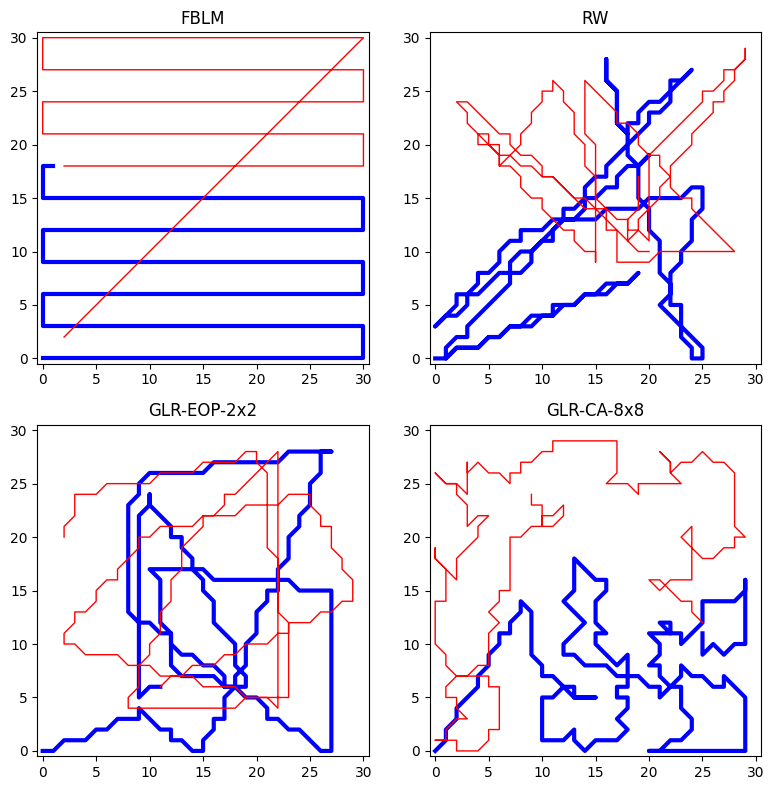

In [19]:
# This code assumes that the experiments had been run and the results were collected in

def draw_half(results, ax):
    """Draws half of the path in red and half in other"""
    empty = np.ones_like(vars(results["wbfe"])["tylcv"].value.T)
    image_env = ax.imshow(empty, vmin=0, vmax=1, origin="lower", cmap="gray")    
    add_robot_path(results, ax, draw_robot = False, from_obs=0, to_obs=200, pathcolor="blue", pathwidth=3)
    add_robot_path(results, ax, draw_robot = False, from_obs=200, to_obs=400, pathcolor="red")


allresults = load_all_results(benchmark_dir)

fig, axes = plt.subplots(2, 2, figsize=(8,8))

result = allresults["FBLM-GP"]
draw_half(result, axes[0,0])
axes[0,0].set_title("FBLM")

result = allresults["RW-GP"]
draw_half(result, axes[0,1])
axes[0,1].set_title("RW")

result = allresults["GLR-EOP-2x2-GP"]
draw_half(result, axes[1,0])
axes[1,0].set_title("GLR-EOP-2x2")

result = allresults["GLR-CA-8x8-GP"]
draw_half(result, axes[1,1])
axes[1,1].set_title("GLR-CA-8x8")

plt.tight_layout()
filename = "IntroFigure.pdf"
plt.savefig(pathlib.Path(benchmark_dir, filename))
plt.show()

# Listing the waypoint numbers
The code here prints out the number of waypoints under a certain path planner.

In [20]:
# Print out the number of waypoints in the various estimators
estimator = "GP"
algorithms = [f"FBLM-{estimator}", f"RW-{estimator}", f"GLR-EOP-2x2-{estimator}", f"GLR-EOP-4x4-{estimator}", f"GLR-EOP-8x8-{estimator}", f"GLR-SD-2x2-{estimator}", f"GLR-SD-4x4-{estimator}", f"GLR-SD-8x8-{estimator}", f"GLR-CA-2x2-{estimator}", f"GLR-CA-4x4-{estimator}", f"GLR-CA-8x8-{estimator}"]

allresults = load_all_results(benchmark_dir)

points = {}
for algorithm in algorithms:
    result = allresults[algorithm]
        #points[algorithm] = len(results["policy"])
    policy = result["robot"].policy
    if isinstance(policy, FollowPathPolicy):
        length = len(result["robot"].policy.waypoints)
        points[algorithm] = length
        print(f"{algorithm} waypoints = {length}")


FBLM-GP waypoints = 22
GLR-EOP-2x2-GP waypoints = 25
GLR-EOP-4x4-GP waypoints = 49
GLR-EOP-8x8-GP waypoints = 129
GLR-SD-2x2-GP waypoints = 211
GLR-SD-4x4-GP waypoints = 203
GLR-SD-8x8-GP waypoints = 175
GLR-CA-2x2-GP waypoints = 213
GLR-CA-4x4-GP waypoints = 169
GLR-CA-8x8-GP waypoints = 169
